<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/main/Copy_of_content_based_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy

In [ ]:
# load the data
dsc_up_df = pd.read_csv(r'/content/dsc_up.csv')
car_dict_df = pd.read_csv(r'/content/car_dict.csv')

dsc_up_df = dsc_up_df.replace({np.NaN: 0})
car_dict_df = car_dict_df.replace({np.NaN: 0})

dsc_up = dsc_up_df.values
car_dict = car_dict_df.values

print(dsc_up.shape)
print(car_dict.shape)

(47086, 35)
(191, 93)


In [ ]:
num_cars = len(car_dict)
print(num_cars)

191


In [ ]:
# balance samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[dsc_up[:, 32] == i]) > 1000:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[dsc_up[:, 32] == i])), size=1000, replace=False)
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(44195, 35)


In [ ]:
# load the label
print(car_dict.shape)
print(dsc_up.shape)

ys_up = dsc_up[:, 32]
print(ys_up)

(191, 93)
(44195, 35)
[0 0 0 ... 190 190 190]


In [ ]:
# transfer the label to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(ys.shape)

(44195, 191)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# column of last feature from 0 and +1
col_last_feature_car = 90
# 80
    #76
col_last_feature_user = 29
car_unscaled = car_dict[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]

# generate the gaussian random no. to budget feature
mu_budget = 0
sigma_budget = 1.5
for i in range(len(user_unscaled)):
    user_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

scalerCar = StandardScaler()
scalerCar.fit(car_dict[:, 1:col_last_feature_car])
car = scalerCar.transform(car_dict[:, 1:col_last_feature_car])

scalerUser = StandardScaler()
scalerUser.fit(dsc_up[:, 1:col_last_feature_user])
user = scalerUser.transform(dsc_up[:, 1:col_last_feature_user])

print(np.allclose(car_unscaled.astype(float), scalerCar.inverse_transform(car)))
print(np.allclose(user_unscaled.astype(float), scalerUser.inverse_transform(user)))

True
True


In [ ]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

In [ ]:
# pca analysis
pca_25 = PCA(n_components=25)
print(pca_25)
pca_25.fit(user)
print(pca_25.explained_variance_ratio_)

# %%
pca_30 = PCA(n_components=2)
print(pca_30)
pca_30.fit(car_dict[:, 1:15])
print(pca_30.explained_variance_ratio_)
c_trans = pca_30.transform(car_dict[:, 1:15])
# plt.plot(c_trans[:, 0], c_trans[:, 1], 'ro')


PCA(n_components=25)
[0.06468094 0.05538773 0.05435404 0.05018585 0.04531846 0.04264035
 0.0393405  0.03708735 0.03622497 0.03591892 0.03575575 0.034984
 0.0347247  0.03415126 0.0336128  0.03313202 0.0326601  0.03227787
 0.03198323 0.03169416 0.03075826 0.0299553  0.02940894 0.02892909
 0.02721245]
PCA(n_components=2)
[9.99902534e-01 7.48293267e-05]


In [ ]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))

ys = ys.reshape(-1, 1)
print(user_vecs.shape)
print(car_vecs.shape)
print(ys.shape)

(8441245, 28)
(8441245, 89)
(8441245, 1)


In [ ]:
ys[ys == 0].shape

(8397050,)

In [ ]:
# # case 2
# car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
# user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
# ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

# car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
# user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
# ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [ ]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

8


In [ ]:
# # case 2
# user_train_one = user_train[(ys_train == 1)[:, 0]]
# user_train_one = gen_car_vecs(user_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# user_train_zero = user_train[(ys_train == 0)[:, 0]]
# user_train = np.concatenate((user_train_zero, user_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(user_train)
# print(user_train.shape)

In [ ]:
# # case 2
# car_train_one = car_train[(ys_train == 1)[:, 0]]
# car_train_one = gen_car_vecs(car_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# car_train_zero = car_train[(ys_train == 0)[:, 0]]
# car_train = np.concatenate((car_train_zero, car_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(car_train)
# print(car_train.shape)

In [ ]:
# # case 2
# ys_one = ys_train[(ys_train == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# ys_zero = ys_train[(ys_train == 0)[:, 0]]
# ys_train = np.concatenate((ys_zero, ys_one), axis=0)
# random.seed(randnum)
# random.shuffle(ys_train)
# print(ys_train.shape)

In [ ]:
# user_vecs_one = user_vecs[(ys == 1)[:, 0]]

In [ ]:
# num_users = user_vecs_one.shape[0]
# print(num_users)


In [ ]:
# user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
# num_zeros = user_vecs_zero.shape[0]
# print(num_zeros)

In [ ]:
# random.seed(randnum)

In [ ]:
# sample_row = np.random.choice(np.arange(num_zeros), size=num_users, replace=False)

In [ ]:
# sample_row

In [ ]:
# user_vecs_zero = user_vecs_zero[sample_row]
# print(user_vecs_zero.shape)

In [ ]:
# case 3
user_vecs_one = user_vecs[(ys == 1)[:, 0]]
# user_vecs_one = gen_car_vecs(user_vecs_one, len(car_dict)-1)
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(user_vecs.shape)

(97229, 28)


In [ ]:
# case3
car_vecs_one = car_vecs[(ys == 1)[:, 0]]
# car_vecs_one = gen_car_vecs(car_vecs_one, len(car_dict)-1)

car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(car_vecs.shape)

(97229, 89)


In [ ]:
# case 3
ys_one = ys[(ys == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, len(car_dict)-1)

ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(ys.shape)

(97229, 1)


In [ ]:
# case 3
car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [ ]:
print(f"cars training data shape:{car_train.shape}")
print(f"cars validating data shape:{car_val.shape}")
print(f"cars testing data shape:{car_test.shape}")

print(f"users training data shape:{user_train.shape}")
print(f"users validating data shape:{user_val.shape}")
print(f"users testing data shape:{user_test.shape}")

print(f"ys training data shape:{ys_train.shape}")
print(f"ys validating data shape:{ys_val.shape}")
print(f"ys testing data shape:{ys_test.shape}")

cars training data shape:(77783, 89)
cars validating data shape:(9723, 89)
cars testing data shape:(9723, 89)
users training data shape:(77783, 28)
users validating data shape:(9723, 28)
users testing data shape:(9723, 28)
ys training data shape:(77783, 1)
ys validating data shape:(9723, 1)
ys testing data shape:(9723, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 89)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           44448       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           60064       ['input_2[0][0]']                
                                                                                              

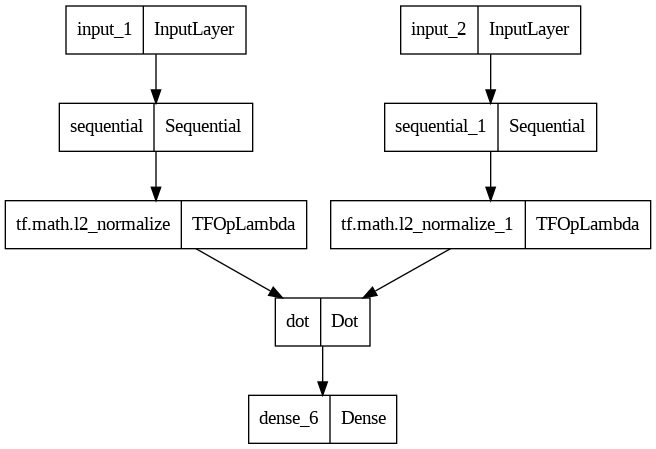

In [ ]:
num_user_features = col_last_feature_user-1
num_car_features = col_last_feature_car-1
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])
car_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_car = tf.keras.layers.Input(shape=(num_car_features))
vc = car_NN(input_car)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

model = tf.keras.Model([input_user, input_car], output)
model.summary()
tf.keras.utils.plot_model(model, "/content/my_model.png")

In [ ]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [ ]:
tf.random.set_seed(1)
model.fit([user_train, car_train], ys_train, epochs=5)

Epoch 1/5
2431/2431 [==============================] - 10s 3ms/step - loss: 0.1604
Epoch 2/5
2431/2431 [==============================] - 8s 3ms/step - loss: 0.1276
Epoch 3/5
2431/2431 [==============================] - 8s 3ms/step - loss: 0.1211
Epoch 4/5
2431/2431 [==============================] - 9s 4ms/step - loss: 0.1179
Epoch 5/5
2431/2431 [==============================] - 8s 3ms/step - loss: 0.1163


In [ ]:
model.evaluate([user_val, car_val], ys_val)

304/304 [==============================] - 1s 2ms/step - loss: 0.1173


0.11727336049079895

In [ ]:
model.evaluate([user_val[(ys_val == 0)[:, 0]], car_val[(ys_val == 0)[:, 0]]], ys_val[(ys_val == 0)[:, 0]])
model.evaluate([user_val[(ys_val == 1)[:, 0]], car_val[(ys_val == 1)[:, 0]]], ys_val[(ys_val == 1)[:, 0]])

140/140 [==============================] - 0s 2ms/step - loss: 0.1489


0.14890863001346588

In [ ]:
ys_test.shape

(9723, 1)

In [ ]:
model.evaluate([user_test[(ys_test == 0)[:, 0]], car_test[(ys_test == 0)[:, 0]]], ys_test[(ys_test == 0)[:, 0]])
model.evaluate([user_test[(ys_test == 1)[:, 0]], car_test[(ys_test == 1)[:, 0]]], ys_test[(ys_test == 1)[:, 0]])

138/138 [==============================] - 0s 2ms/step - loss: 0.1493


0.1493450552225113

In [ ]:
ys_p_test = model.predict([[user_test, car_test]])
ys_p_test_vs = np.concatenate((ys_p_test, ys_test), axis=1)
ys_test_df = pd.DataFrame(ys_p_test_vs)
ys_test_df.to_csv(r'/content/ys_p_test_6epoch.csv', encoding='UTF-8')

304/304 [==============================] - 1s 2ms/step


In [ ]:
# print the confusion matrix & report
print(confusion_matrix(ys_test, np.round(ys_p_test)))
print(classification_report(ys_test, np.round(ys_p_test)))

[[4556  780]
 [ 899 3488]]
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84      5336
         1.0       0.82      0.80      0.81      4387

    accuracy                           0.83      9723
   macro avg       0.83      0.82      0.83      9723
weighted avg       0.83      0.83      0.83      9723



AUC: 0.9117589954168117


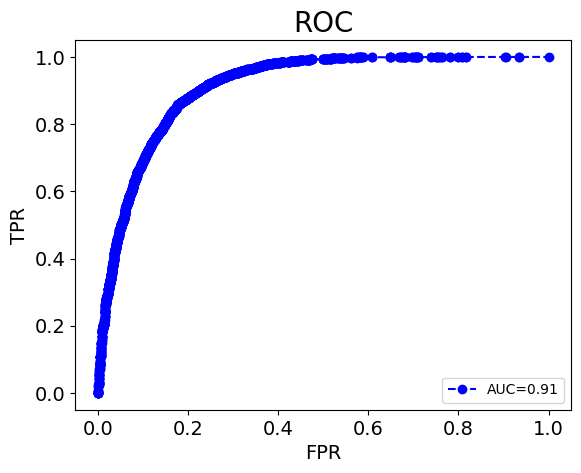

In [ ]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_test, ys_p_test)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

In [ ]:
ys_p_train = model.predict([[user_train, car_train]])

2431/2431 [==============================] - 5s 2ms/step


In [ ]:
# print the confusion matrix & report
print(confusion_matrix(ys_train, np.round(ys_p_train)))
print(classification_report(ys_train, np.round(ys_p_train)))

[[36542  5893]
 [ 6880 28468]]
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85     42435
         1.0       0.83      0.81      0.82     35348

    accuracy                           0.84     77783
   macro avg       0.84      0.83      0.83     77783
weighted avg       0.84      0.84      0.84     77783



基于某个用户，预测不同的车的购买倾向

In [ ]:
list = []
for i in range(len(dsc_up)):
  if dsc_up[i, 32] == 7:
    list.append(i)
print(list)

[2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 220

In [ ]:
dsc_up[2047, :]

array([3358153, 3, 3, 3, 2, 3, 3, 4, 3, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2300, 3, 7.911861159554745, 5,
       3, 24, '宋Pro', 5178, 40569, 7, '2019款 1.5T 自动豪华型', 40569],
      dtype=object)

In [ ]:
# predict the new car of new performance for specific user
# define the cars and the user
row_car_dict = np.arange(0, num_cars) 
row_user_dst = [2047]
new_car = car_unscaled[row_car_dict]
new_user = gen_car_vecs(user_unscaled[row_user_dst], len(row_car_dict))

# predict the new car of new performance
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])
print(f'target car is {dsc_up[row_user_dst, 33]}, car No. is {dsc_up[row_user_dst, 32]}')
for i in range(len(row_car_dict)):
    print(
        f'{i} :'
        f'{car_dict[row_car_dict, 91].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[row_car_dict == dsc_up[row_user_dst, 32]] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))


[[186   4]
 [  0   1]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       190
         1.0       0.20      1.00      0.33         1

    accuracy                           0.98       191
   macro avg       0.60      0.99      0.66       191
weighted avg       1.00      0.98      0.99       191



In [ ]:
dsc_up[row_user_dst, 32]

array([7], dtype=object)

In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_car_predict_vs.csv', encoding='UTF-8')

基于某款车预测不同用户的购买倾向

In [ ]:
row_car_dict = [7]
row_user_dst = np.arange(0, num_users)
new_car = gen_car_vecs(car_unscaled[row_car_dict], len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 91]}, car No. is {car_dict[row_car_dict, 92]}')
for i in range(min(len(row_user_dst), 200)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.86] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[dsc_up[row_user_dst, 32] == row_car_dict] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))

[[29750 13445]
 [  212   788]]
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81     43195
         1.0       0.06      0.79      0.10      1000

    accuracy                           0.69     44195
   macro avg       0.52      0.74      0.46     44195
weighted avg       0.97      0.69      0.80     44195



In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_vs = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_user_predict_vs3.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.86].shape

(14233,)

修改某款车性能参数，预测不同用户的购买倾向

In [ ]:
# 32 宋DMIDMI110km
# 56 低配影酷
car_unscaled[56, 0]

11.98

In [ ]:
# base car parameters
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
print(new_car_one)

[[11.98 7 1 2 1 0.0 0.0 130 270 1 190 8.35 0 735 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
# modify the paramters of some car
new_car_one[:, 0:14] = car_unscaled[32, 0:14]
print(new_car_one)

[[17.58 4 1 3 3 0.7 5.5 81 135 1 170 7.9 110 1443 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

297/297 [==============================] - 1s 2ms/step
target car is ['影酷 2022款 1.5T DCT基本型'], car No. is [56]
User0 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User1 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User2 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User3 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User4 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User5 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User6 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User7 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User8 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User9 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.844] : [1.]
User10 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User11 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
User12 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.855] : [1.]
Us

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.8].shape

(3196,)

In [ ]:
dsc_up.shape

(9492, 33)

修改用户地点，预测用户购买某款车的倾向变化

In [ ]:
row_car_dict = [11]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

In [ ]:
# modify the place of users
# 吉林：26 长春：295
# 广东：1 广州：115
# 广东：1 深圳：195
new_user[:, (22,24)] = [(115, 1)]
print(new_user[0:10,(22,24)])

[[115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]]


In [ ]:
new_user[0]

array([3, 3, 2, 3, 2, 3, 3, 3, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 100, 115, 12.383482437349597, 1, 0, 7],
      dtype=object)

In [ ]:
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

297/297 [==============================] - 1s 2ms/step
target car is ['AION V 2023款 Plus 70 智享科技版 磷酸铁锂'], car No. is [11]
User0 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.047] : [0.]
User1 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.043] : [0.]
User2 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.026] : [0.]
User3 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.057] : [0.]
User4 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.069] : [0.]
User5 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.034] : [0.]
User6 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.027] : [0.]
User7 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.02] : [0.]
User8 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.047] : [0.]
User9 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.042] : [0.]
User10 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.046] : [0.]
User11 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.047] : [0.]
User12 who has bought car:['影酷 2022款 1.5T 超新星PRO版'] : [0.059]

In [ ]:
threshold_p = 0.23
new_y_predict [new_car_predict > threshold_p].shape

(460,)

In [ ]:
num_users

9492

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > threshold_p] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_place.csv', encoding='UTF-8')

**others：**

In [ ]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 30].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict3.csv', encoding='UTF-8')

In [ ]:
a = np.array([0,1,2])
b = np.array([1,2,3])
print(np.dot(a,b))

8
